<font size="5">
 <div class="alert alert-block alert-info"> <b> Objetivo 3 - Modelo Hibrido | avg mill price consumer <b>
     </div>
</font>

      
    
  <font size="4"> MCD - Análise de Séries Temporais e Previsão </font>
  

    
  <font size="3">ISCTE-IUL </font>

<font size="4"> **Agenda** </font>  
  
- Imports and Defines
  - Imports
  - Define Function
- Data
- Data Vizualization and Preparation
- Classic Model(ARIMA) for Trend
  - Pre-processing
  - Model training
  - Model Comparison based on Information Criteria
  - Selected Models Information Criteria Comparison
  - Model Prediction Overview
  - ARIMA Model Forecast
- DNN Model for Noise
  - Model Cross Validation
  - Model Forecast
- Classic Model + DNN Model Forecast

# Imports and Defines

## Imports

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")

## Define Functions

In [2]:
# Compute MAE over an array of different horizons
def horizon_mae(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[0,:i]), 2))
    return list_MAE;

In [3]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true.T) / y_true.T));

In [4]:
# Compute MAPE over an array of different horizons
def horizon_mape(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[0,:i]), 2))
        return list_MAPE;

In [5]:
# Evaluate combinations of p, d and q values for an ARIMA model
def ARIMA_grid(dataset, arimaCfg, isLog, stepsToForecast):
    df_IC = pd.DataFrame(columns=['ARIMA(p, d, q)', 'AIC', 'BIC', 'HQIC'])
    df_IC.set_index('ARIMA(p, d, q)', inplace=True)
    dict_arimaFit = {}
    dict_arimaPred = {}
    modelNum = 0
    totalModelNum = len(arimaCfg.p_range) * len(arimaCfg.d_range) * len(arimaCfg.q_range)

    for p in arimaCfg.p_range:
        for d in arimaCfg.d_range:
            for q in arimaCfg.q_range:
                order = (p, d, q)
                modelNum += 1
                print(f"{modelNum}/{totalModelNum}")

                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()

                    # Check if the model is fitted successfully
                    model_str = f'ARIMA{order}'
                    df_IC = pd.concat([df_IC, pd.DataFrame({
                        'AIC': model_fit.aic,
                        'BIC': model_fit.bic,
                        'HQIC': model_fit.hqic
                    }, index=[model_str])])

                    if isLog:
                        dict_arimaFit[model_str] = np.e ** (model_fit.predict(typ='levels'))
                        dict_arimaPred[model_str] = np.e ** (model_fit.forecast(steps=stepsToForecast[-1]))
                    else:
                        dict_arimaFit[model_str] = model_fit.predict(typ='levels')
                        dict_arimaPred[model_str] = model_fit.forecast(steps=stepsToForecast[-1])

                except Exception as e:
                    print(f"Error fitting ARIMA{order}: {e}")
                    continue

    return dict_arimaFit, dict_arimaPred, df_IC

# Data

In [2]:
# To use CSV files - Example
df = pd.read_csv("../data/data_avg_milk_price_consumer.csv")
df = df.rename(columns={'observation_date': 'Date', 'APU0000709112': 'Value'})
df.set_index('Date', drop=True, inplace=True)
df.index = pd.to_datetime(df.index)
df = df.truncate(before='1995-01', after='2023-03')

title = 'Average Price: Milk, Fresh, Whole, Fortified (Cost per Gallon/3.8 Liters) in U.S. City Average'
serie = "Average Price to Consumer"
xlab = 'Months/Year';
ylab = 'U.S. Dollars';

seasonal_periods = 4
stepsToForecast = [1, 3, 12]

train_values = df[['Value']][:-stepsToForecast[-1]-2].rename(columns={'Value': 'train'})
test_values = df[['Value']][-(stepsToForecast[-1]+2):].rename(columns={'Value': 'test'})

# Data vizualization and Preparation

Text(0.5, 1.0, 'Additive Residuals')

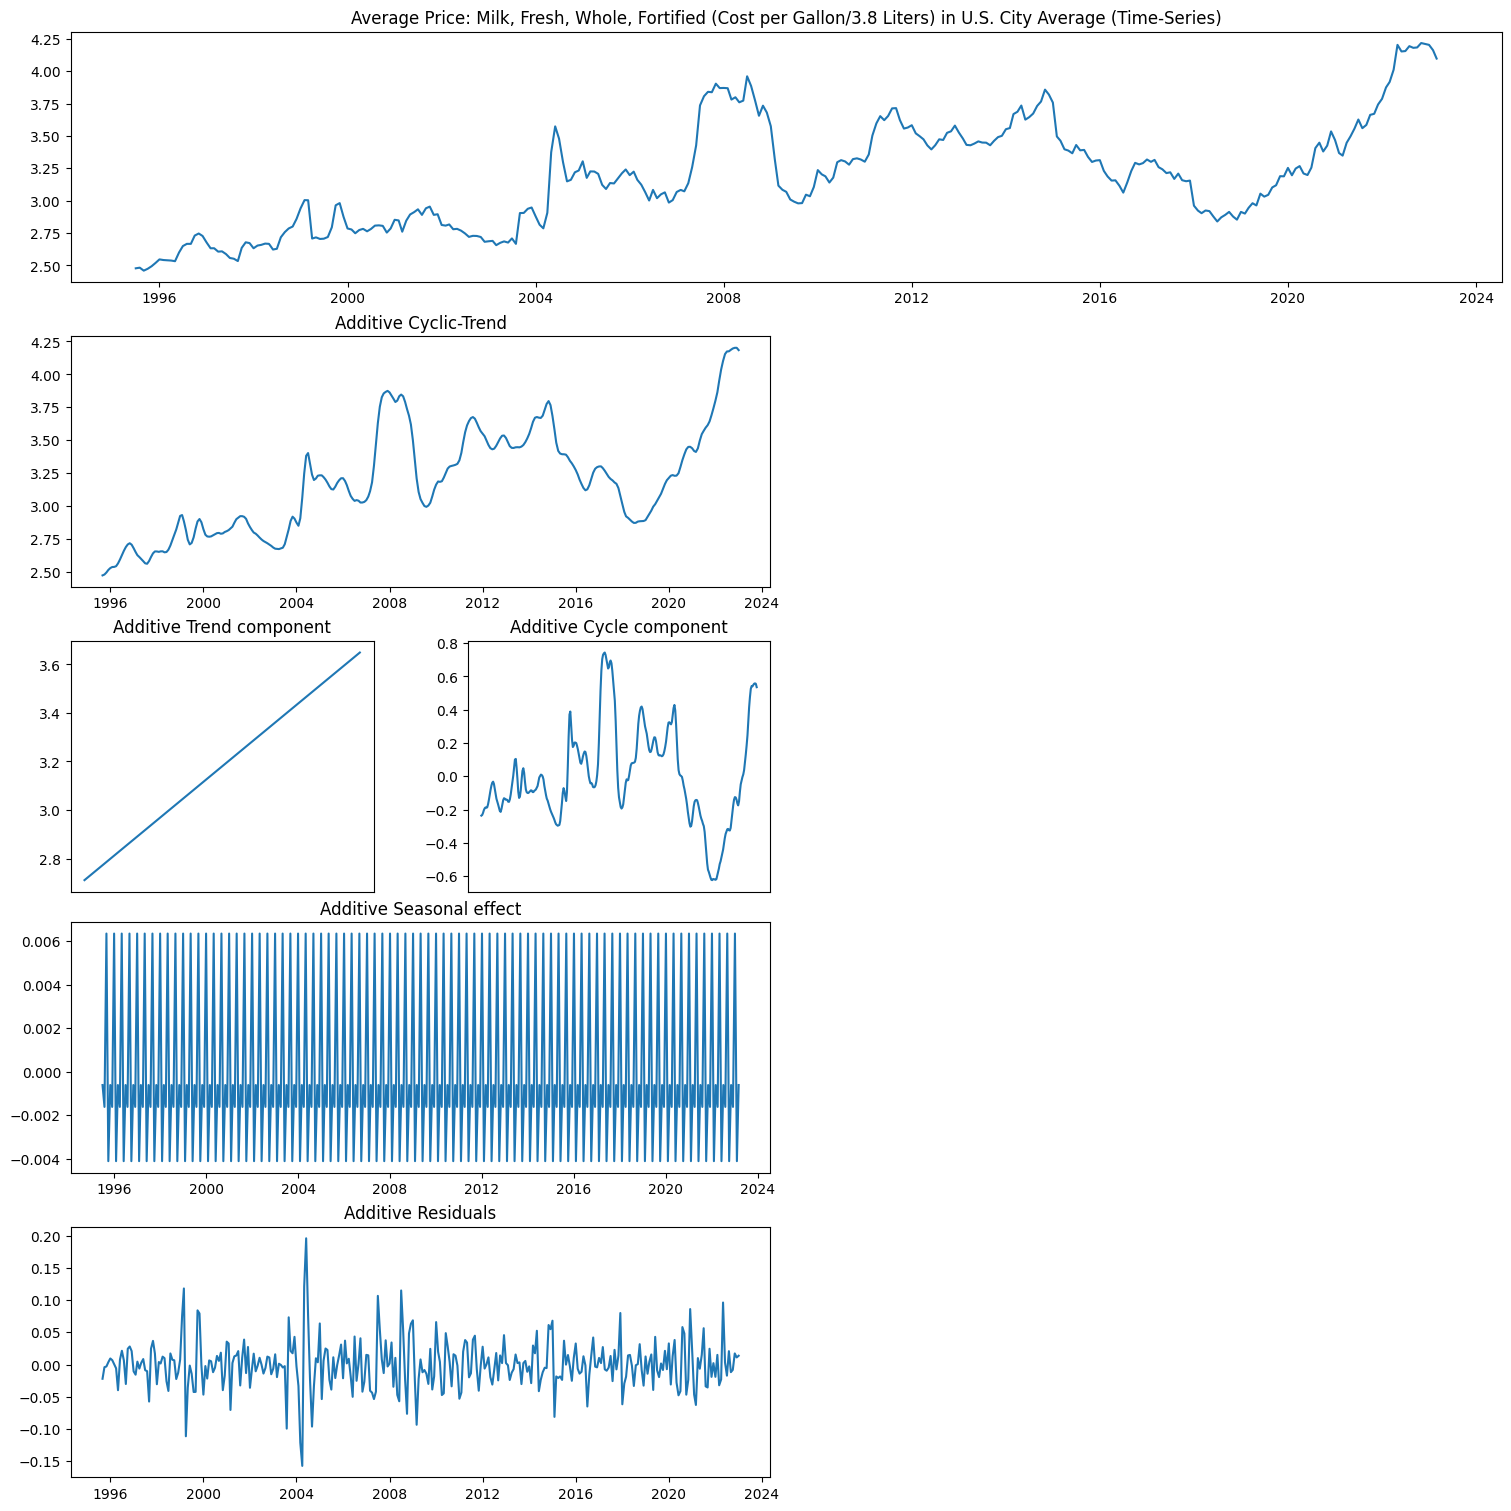

In [8]:
# As it should be known, a time series can typically be decomposed as:
#Additive Time Series = Level + CyclicTrend + Residual + Seasonality
#Multiplicative Time Series = Level*CyclicTrend*Residual*Seasonality

# Therefore, we will decompose the time series assuming it is both an additive and multiplicative model
#and we will infer in its type based on the residual fit given at the end

# Seasonal decomposition using moving averages
resultAdd = seasonal_decompose(df, model='additive',       period=seasonal_periods)

# Hodrick-Prescott filter
# See Ravn and Uhlig: http://home.uchicago.edu/~huhlig/papers/uhlig.ravn.res.2002.pdf
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend[resultAdd.trend.notna().values], lamb=lamb)

fig = plt.figure(figsize=(15,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

fig.add_subplot(spec[0, :])
plt.plot(df)

plt.title(title + ' (Time-Series)')
# Additive model
fig.add_subplot(spec[1, :2])
plt.plot(resultAdd.trend)
plt.title('Additive Cyclic-Trend')
fig.add_subplot(spec[2, 0])
plt.plot(trendAdd)
plt.xticks([])
plt.title('Additive Trend component')
fig.add_subplot(spec[2, 1])
plt.plot(cycleAdd)
plt.xticks([])
plt.title('Additive Cycle component')
fig.add_subplot(spec[3, :2])
plt.plot(resultAdd.seasonal)
plt.title('Additive Seasonal effect')
fig.add_subplot(spec[4, :2])
plt.plot(resultAdd.resid)
plt.title('Additive Residuals')


In [9]:
previousStepsToShow = 15;

resid_df = pd.DataFrame(resultAdd.resid)
resid_df.columns = ['Value']  # renomeia para manter consistência com o restante código
resid_df.dropna(inplace=True)
trend_df = pd.DataFrame(resultAdd.trend)
trend_df.columns = ['Value']  # renomeia para manter consistência com o restante código
trend_df.dropna(inplace=True)


df_train = trend_df[['Value']][:-stepsToForecast[-1]].rename(columns={'Value': 'train'})
df_test = trend_df[['Value']][-stepsToForecast[-1]:].rename(columns={'Value': 'test'})
resid_train = resid_df[['Value']][:-stepsToForecast[-1]].rename(columns={'Value': 'train'})
resid_test  = resid_df[['Value']][-stepsToForecast[-1]:].rename(columns={'Value': 'test'})

# Classic Model(ARIMA) for Trend

## Pre-processing

In [ ]:
isLog = False

if (isLog):
    df_Train = pd.DataFrame(np.log(df_train), index = df_train.index).copy()
else:
    df_Train = df_train.copy()


## Model training

In [ ]:
# Range of ARIMA models to compute
class arimaCfg:
    p_range = range(1, 5) # [1,7)
    d_range = range(1, 2) # [1,3)
    q_range = range(1, 4) # [1,7)

dict_arimaFit, dict_arimaPred, df_IC = ARIMA_grid(df_train.values, arimaCfg, isLog, stepsToForecast)
#dict_arimaFit, dict_arimaPred, df_IC

1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


## Model Comparison based on Information Criteria

In [ ]:
print(df_IC[['AIC']].sort_values('AIC').head().rename(columns={'AIC': 'TOP 5 AIC'}))
print(" ")
print(df_IC[['BIC']].sort_values('BIC').head().rename(columns={'BIC': 'TOP 5 BIC'}))
print(" ")
print(df_IC[['HQIC']].sort_values('HQIC').head().rename(columns={'HQIC': 'TOP 5 HQIC'}))

                  TOP 5 AIC
ARIMA(3, 1, 3) -2030.909869
ARIMA(2, 1, 3) -2007.254373
ARIMA(2, 1, 2) -1937.739383
ARIMA(2, 1, 1) -1937.734027
ARIMA(1, 1, 3) -1937.045722
 
                  TOP 5 BIC
ARIMA(3, 1, 3) -2004.619674
ARIMA(2, 1, 3) -1984.719919
ARIMA(2, 1, 1) -1922.711058
ARIMA(2, 1, 2) -1918.960672
ARIMA(1, 1, 3) -1918.267011
 
                 TOP 5 HQIC
ARIMA(3, 1, 3) -2020.407097
ARIMA(2, 1, 3) -1998.251997
ARIMA(2, 1, 1) -1931.732443
ARIMA(2, 1, 2) -1930.237403
ARIMA(1, 1, 3) -1929.543742


## Selected Models Information Criteria Comparison

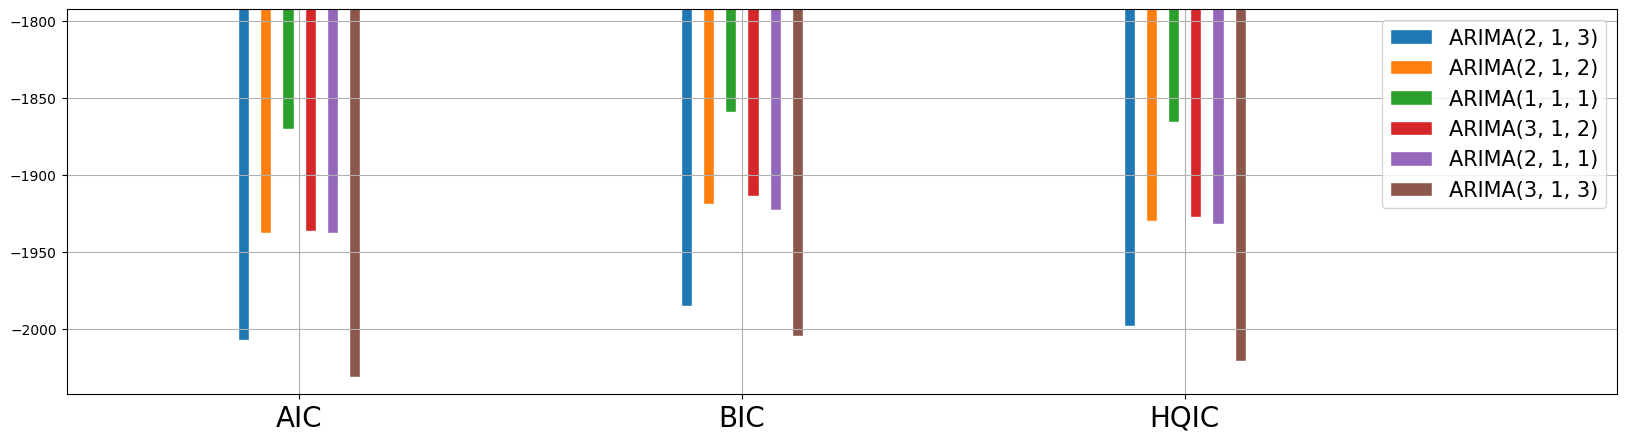

In [ ]:
labels = ['ARIMA(2, 1, 3)',
          'ARIMA(2, 1, 2)',
          'ARIMA(1, 1, 1)',
          'ARIMA(3, 1, 2)',
          'ARIMA(2, 1, 1)',
          'ARIMA(3, 1, 3)']


plt.figure(figsize=(20,5))
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
spacing = 0.05
barWidth = 0.025
r = np.arange(3) - ((len(labels)/2)-1)*spacing

for i in np.arange(len(labels)):
    plt.bar(r, df_IC.loc[labels[i]].values, width=barWidth, edgecolor='white', label=labels[i])
    r = [x + spacing for x in r]
 
plt.xticks([r + barWidth for r in range(3)], ['AIC', 'BIC', 'HQIC'], fontsize='20')
plt.axis((-0.5, 3.0, min(df_IC.min())-0.05*(max(df_IC.max())-min(df_IC.min())), max(df_IC.max())+0.05*(max(df_IC.max())-min(df_IC.min()))))
plt.legend(loc='best')
plt.grid()
plt.show()

## Model Prediction Overview

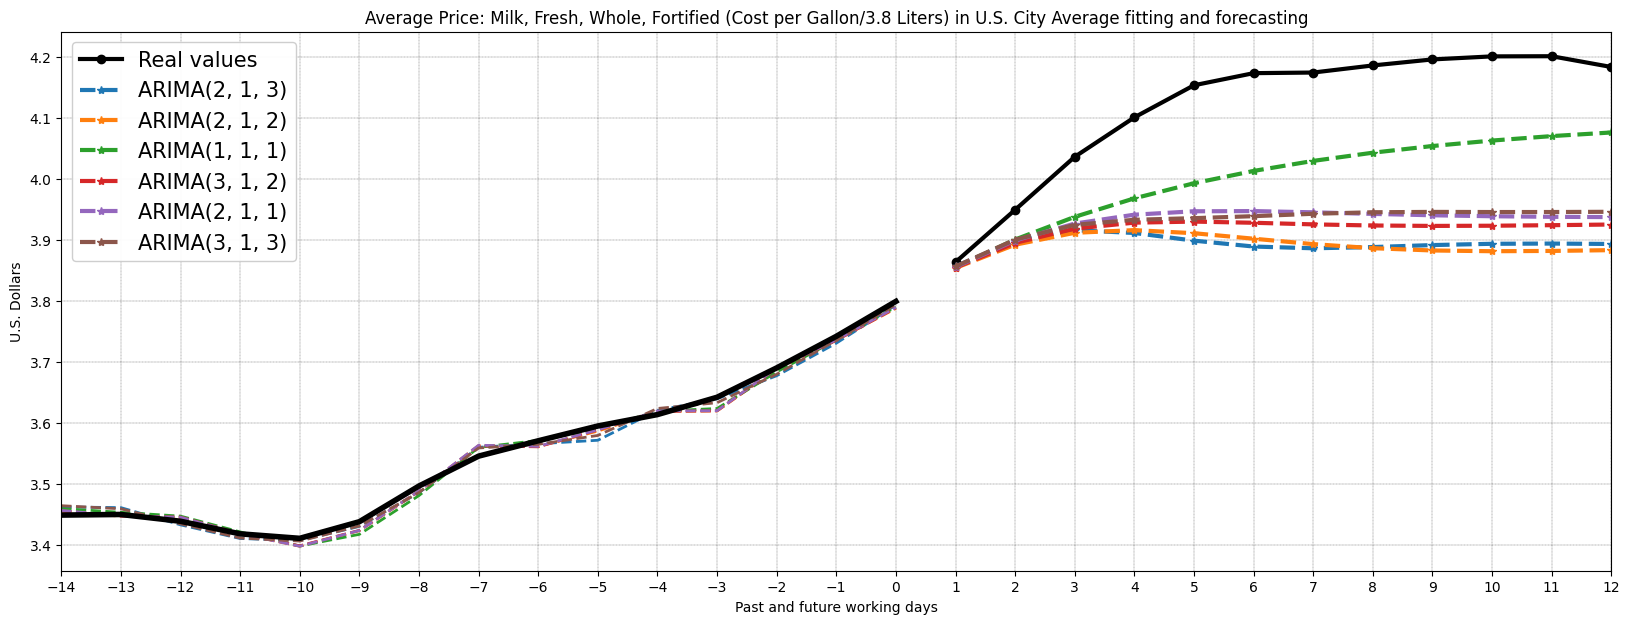

ARIMA(2, 1, 3)
Prediction for 1 Months/Year: MAE = 0.01 (0.18%)
Prediction for 3 Months/Year: MAE = 0.06 (1.48%)
Prediction for 12 Months/Year: MAE = 0.23 (5.4%)

ARIMA(2, 1, 2)
Prediction for 1 Months/Year: MAE = 0.01 (0.25%)
Prediction for 3 Months/Year: MAE = 0.06 (1.59%)
Prediction for 12 Months/Year: MAE = 0.23 (5.45%)

ARIMA(1, 1, 1)
Prediction for 1 Months/Year: MAE = 0.01 (0.22%)
Prediction for 3 Months/Year: MAE = 0.05 (1.3%)
Prediction for 12 Months/Year: MAE = 0.12 (2.84%)

ARIMA(3, 1, 2)
Prediction for 1 Months/Year: MAE = 0.01 (0.23%)
Prediction for 3 Months/Year: MAE = 0.06 (1.51%)
Prediction for 12 Months/Year: MAE = 0.2 (4.84%)

ARIMA(2, 1, 1)
Prediction for 1 Months/Year: MAE = 0.01 (0.2%)
Prediction for 3 Months/Year: MAE = 0.06 (1.4%)
Prediction for 12 Months/Year: MAE = 0.19 (4.52%)

ARIMA(3, 1, 3)
Prediction for 1 Months/Year: MAE = 0.01 (0.18%)
Prediction for 3 Months/Year: MAE = 0.06 (1.39%)
Prediction for 12 Months/Year: MAE = 0.19 (4.52%)



In [ ]:
labels = ['Real Closing price',
          'ARIMA(2, 1, 3)',
          'ARIMA(2, 1, 2)',
          'ARIMA(1, 1, 1)',
          'ARIMA(3, 1, 2)',
          'ARIMA(2, 1, 1)',
          'ARIMA(3, 1, 3)']


plt.figure(figsize=(20,7))
plt.title(title + ' fitting and forecasting')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o', linewidth = 3, label='Real values')
for i in np.arange(len(labels)-1):
    arimaPlot = plt.plot(1+np.arange(stepsToForecast[-1]), dict_arimaPred[labels[i+1]], '--*' , linewidth = 3, label = labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_arimaFit[labels[i+1]][-previousStepsToShow:], '--' , linewidth = 2, color=arimaPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 ) # label = labels[i+1]  legenda
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow,+stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future working days')
plt.ylabel(ylab);
plt.show()

for i in np.arange(len(labels[1:])):
    mae  = horizon_mae(df_test.values, dict_arimaPred[labels[i+1]], stepsToForecast)
    mape = horizon_mape(df_test.values, dict_arimaPred[labels[i+1]], stepsToForecast)
    print(labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )
    print("")

## ARIMA Model Forecast

In [ ]:
model = ARIMA(df_train, order=(1, 1, 1))  # ou outro melhor, como (2,1,2)
model_fit = model.fit()


In [ ]:
steps = len(df_test)# ou stepsToForecast[-1]

forecast_arima = model_fit.forecast(steps=steps)


In [ ]:
forecast_in_sample_trend = model_fit.fittedvalues  # previsão dentro do treino

# DNN Model for Noise

## Model Cross Validation

In [10]:
def create_lagged_data(series, lags):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i-lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

lags = 5
X, y = create_lagged_data(resid_train.to_numpy(), lags)
X = X.reshape((X.shape[0], X.shape[1], 1))  # 3D para LSTM



--- Fold 1 ---
Fold 1 MAE: 0.027954940466871043


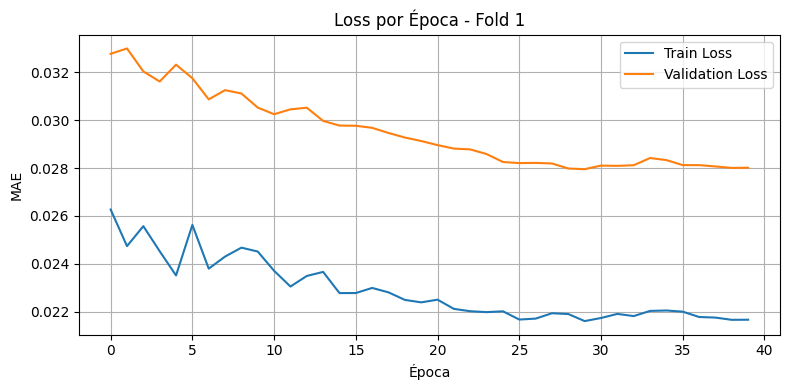


--- Fold 2 ---
Fold 2 MAE: 0.03197180030723392


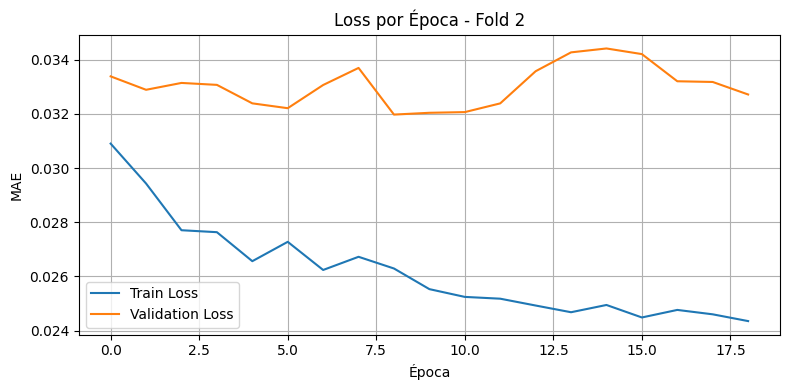


--- Fold 3 ---
Fold 3 MAE: 0.02060005183548315


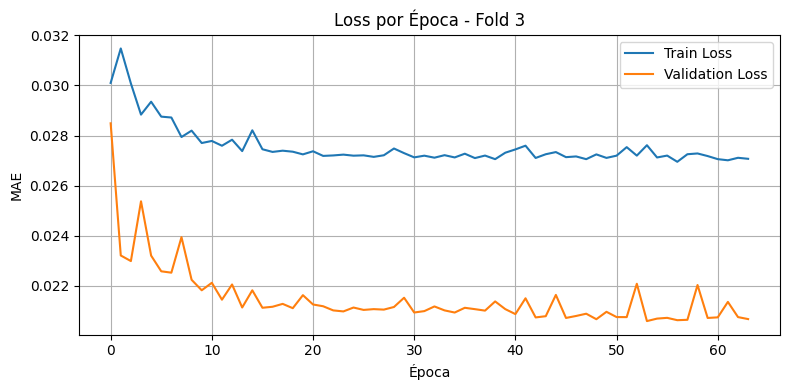


--- Fold 4 ---
Fold 4 MAE: 0.01934394505021373


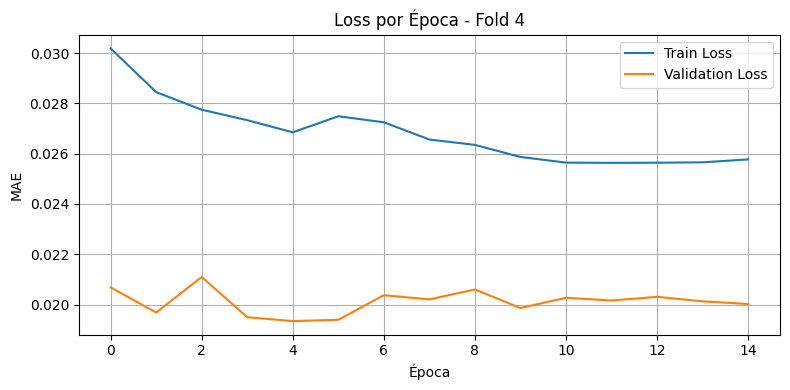


--- Fold 5 ---
Fold 5 MAE: 0.023327439174547968


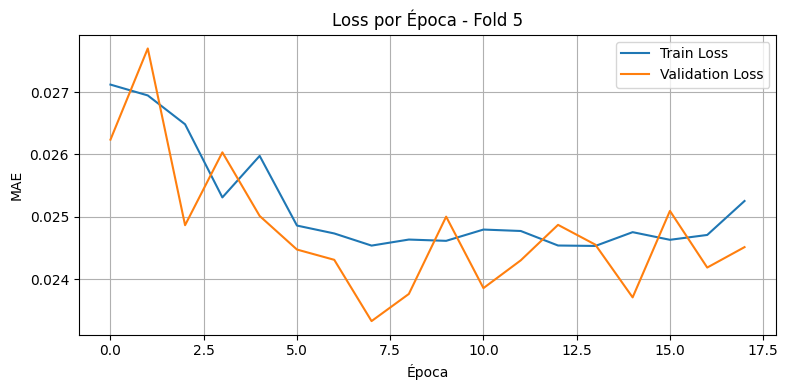

In [11]:
# Supondo que X e y já estão definidos e X tem shape (n amostras, lags, 1)

tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\n--- Fold {fold+1} ---")
    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = Sequential()
    model.add(LSTM(200, input_shape=(X.shape[1], 1), activation='tanh', return_sequences=False))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mae')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Previsão e avaliação
    y_pred = model.predict(X_val, verbose=0)
    

    mae = mean_absolute_error(y_val, y_pred)
    print(f"Fold {fold+1} MAE:", mae)


    # 🔽 Gráfico da loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss por Época - Fold {fold+1}')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()  
    plt.show()


## Model Forecast

In [12]:
def forecast_residuals(model, resid_train, steps, lags):
    """
    Gera previsão passo-a-passo para resíduos com base na rede treinada.
    """
    # 🔧 Garante que estás a trabalhar com array
    resid_train = resid_train.to_numpy() if hasattr(resid_train, 'to_numpy') else resid_train

    forecast = []
    input_seq = resid_train[-lags:].reshape(1, lags, 1)

    for _ in range(steps):
        next_val = model.predict(input_seq, verbose=0)[0, 0]
        forecast.append(next_val)

        # Atualizar a sequência para o passo seguinte
        input_seq = np.append(input_seq[:, 1:, :], [[[next_val]]], axis=1)

    return np.array(forecast)


In [13]:
# Corrigir: garantir que usas os resíduos escalados
pred_resid = forecast_residuals(model, resid_train, steps=len(resid_test), lags=lags)


# Classic Model + DNN Model Forecast

In [ ]:
forecast_out_sample = forecast_arima + pred_resid

In [ ]:
val_indices = val_idx  # índices da validação no fold atual
val_dates = resid_train.iloc[val_indices].index

# 1. Garante que forecast_in_sample_trend é uma Series com índice datetime
assert isinstance(forecast_in_sample_trend, pd.Series)
assert isinstance(forecast_in_sample_trend.index, pd.DatetimeIndex)

# 2. Garante que y_pred tem a mesma dimensão
assert len(val_dates) == y_pred.shape[0]

# 3. Converter y_pred para Series com índice temporal correto
forecast_in_sample_resid = pd.Series(y_pred.flatten(), index=val_dates)

# 4. Soma previsões
forecast_in_sample = forecast_in_sample_trend[val_dates] + forecast_in_sample_resid



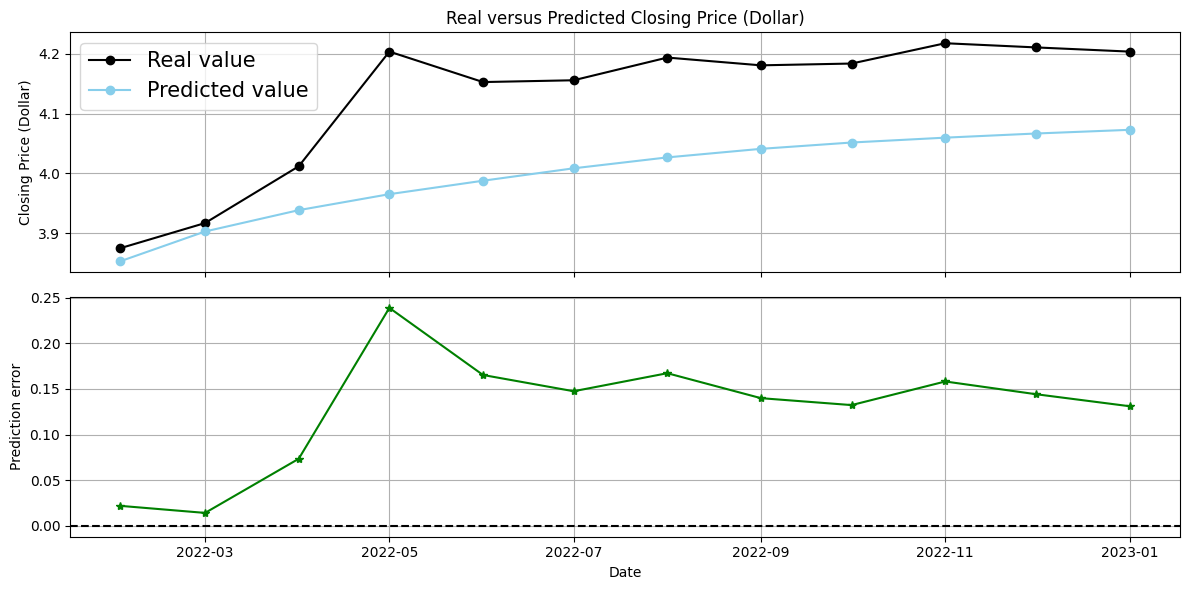

Horizon Evaluation for Final Hybrid Model:
Prediction for 1 Months/Year: MAE = 0.02 (0.56%)
Prediction for 3 Months/Year: MAE = 0.04 (0.92%)
Prediction for 12 Months/Year: MAE = 0.13 (3.06%)


In [ ]:
# Índice temporal
aligned_test = test_values.iloc[:-2].copy()
index = aligned_test.index

# Série real original
real = aligned_test['test'].to_numpy()

# Previsão final híbrida (tendência + ruído)
pred = forecast_out_sample.to_numpy()

# Calcular erros
errors = real - pred

# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# 1. Real vs Previsão
axs[0].plot(index, real, 'k-o', label='Real value')
axs[0].plot(index, pred, 'k-o',color='skyblue', label='Predicted value')
axs[0].set_title('Real versus Predicted Closing Price (Dollar)')
axs[0].set_ylabel('Closing Price (Dollar)')
axs[0].legend()
axs[0].grid(True)

# 2. Erros
axs[1].plot(index, errors, 'g-*')
axs[1].axhline(y=0, linestyle='--', color='k')
axs[1].set_ylabel('Prediction error')
axs[1].set_xlabel('Date')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# --- Avaliação com métricas horizon ---
mae = horizon_mae(real.reshape(-1, 1), pred, stepsToForecast)
mape = horizon_mape(real.reshape(-1, 1), pred, stepsToForecast)

print("Horizon Evaluation for Final Hybrid Model:")
for i in np.arange(len(stepsToForecast)):
    print(f"Prediction for {stepsToForecast[i]} {xlab}: MAE = {round(mae[i], 2)} ({round(mape[i], 2)}%)")





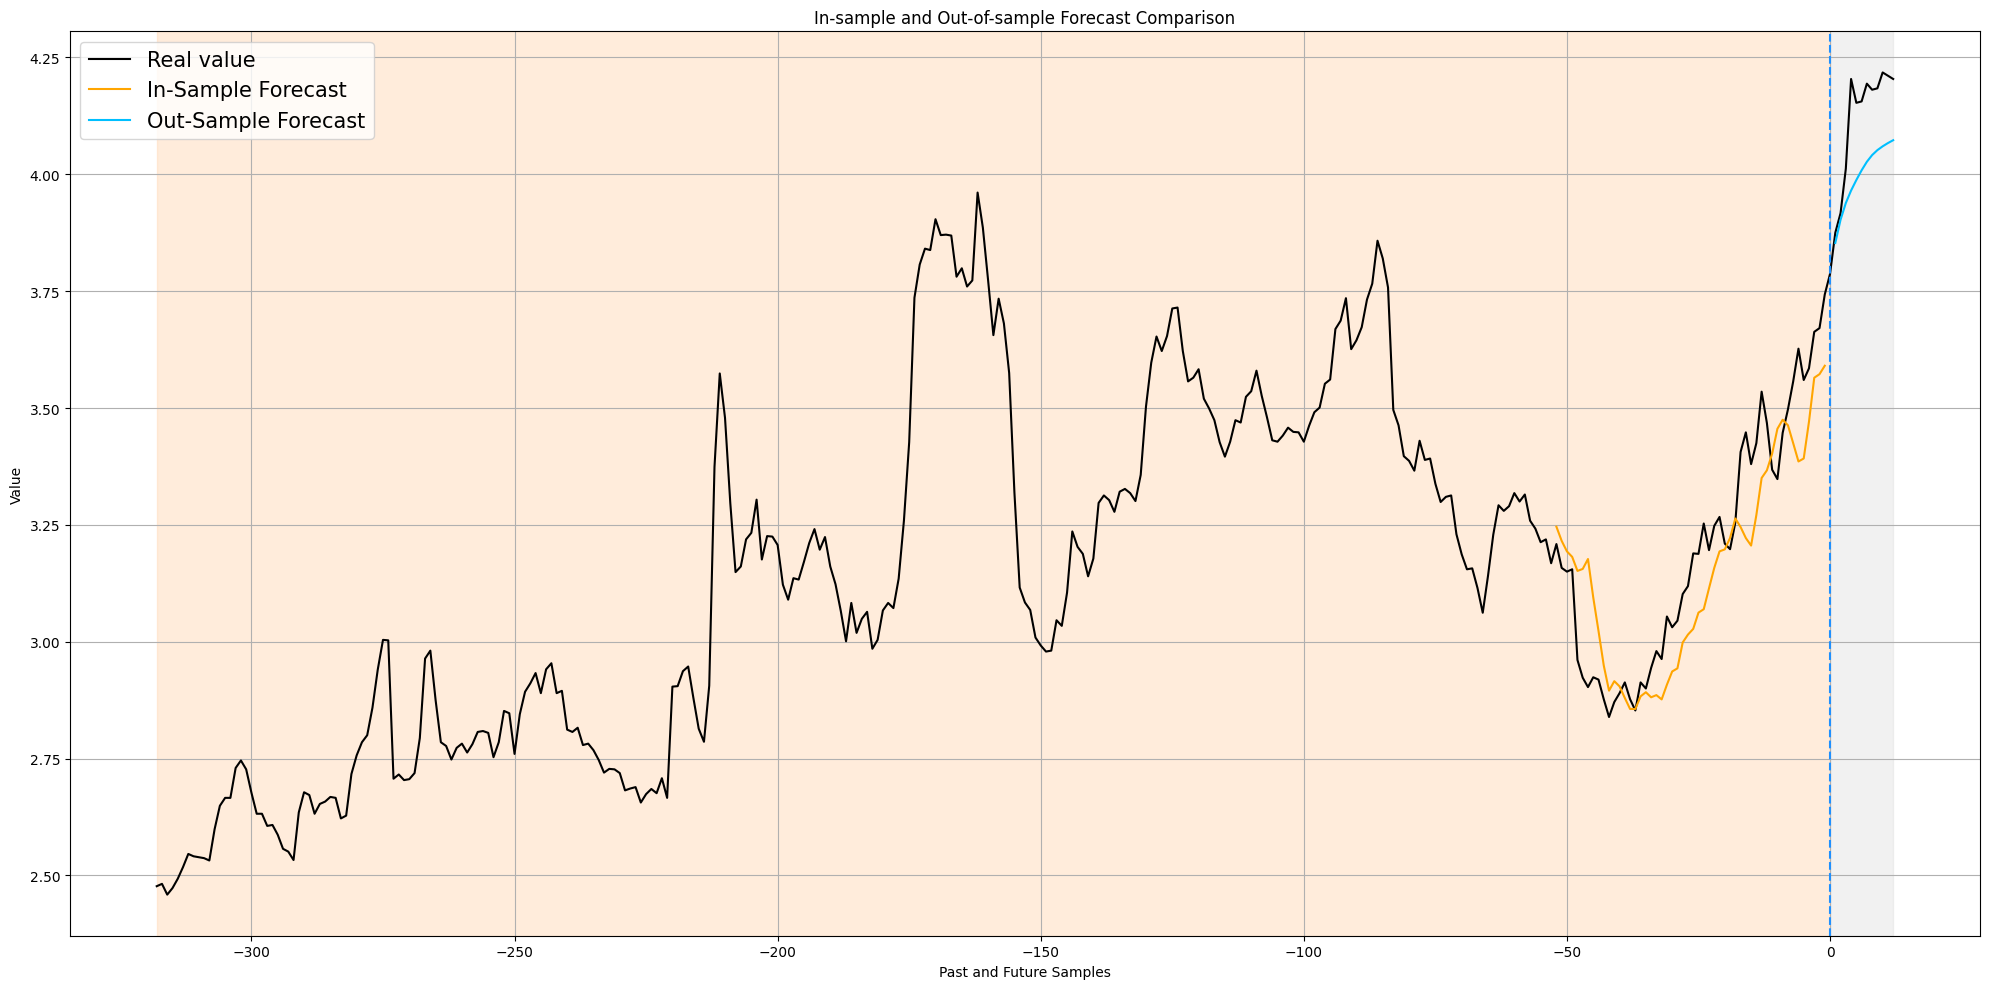

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


real_train = train_values.to_numpy().flatten()

real_test = aligned_test['test'].values.flatten()

# Construção do eixo temporal artificial
x_real = np.arange(-len(real_train) + 1, len(real_test) + 1)
x_in_sample = np.arange(-len(forecast_in_sample), 0)
x_out_sample = np.arange(1, len(forecast_out_sample) + 1)

# Gráfico
plt.figure(figsize=(20, 10))
plt.title('In-sample and Out-of-sample Forecast Comparison')

# Série real (linha preta)
plt.plot(x_real, np.concatenate([real_train, real_test]), 'k-', label='Real value')

# Previsões
plt.plot(x_in_sample, forecast_in_sample, color='orange', label='In-Sample Forecast')
plt.plot(x_out_sample, forecast_out_sample, color='deepskyblue', label='Out-Sample Forecast')

# Destaques visuais
plt.axvspan(x_real[0], 0, color='peachpuff', alpha=0.5)   # zona treino
plt.axvspan(0, x_real[-1], color='lightgray', alpha=0.3)  # zona teste
plt.axvline(0, color='dodgerblue', linestyle='--')       # divisão treino/teste

plt.xlabel('Past and Future Samples')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
